## Hourly Consumption Profiling / PowerFactor Analysis / inefficient households

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from matplotlib_venn import venn3
import numpy as np
# to view all columns in a dataframe
pd.set_option('display.max_columns', None)

### Clustering

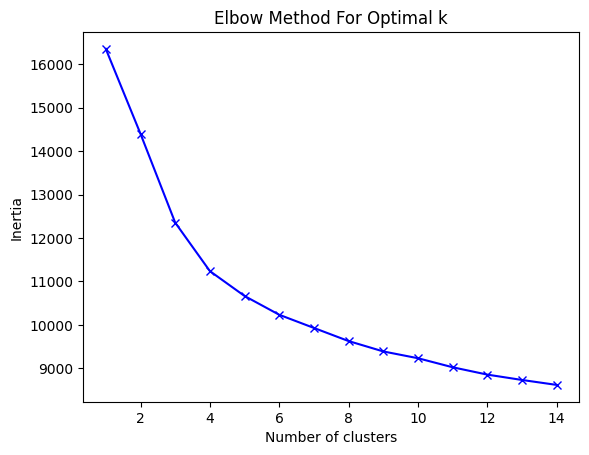

Text(0, 0.5, 'Principal Component 2')

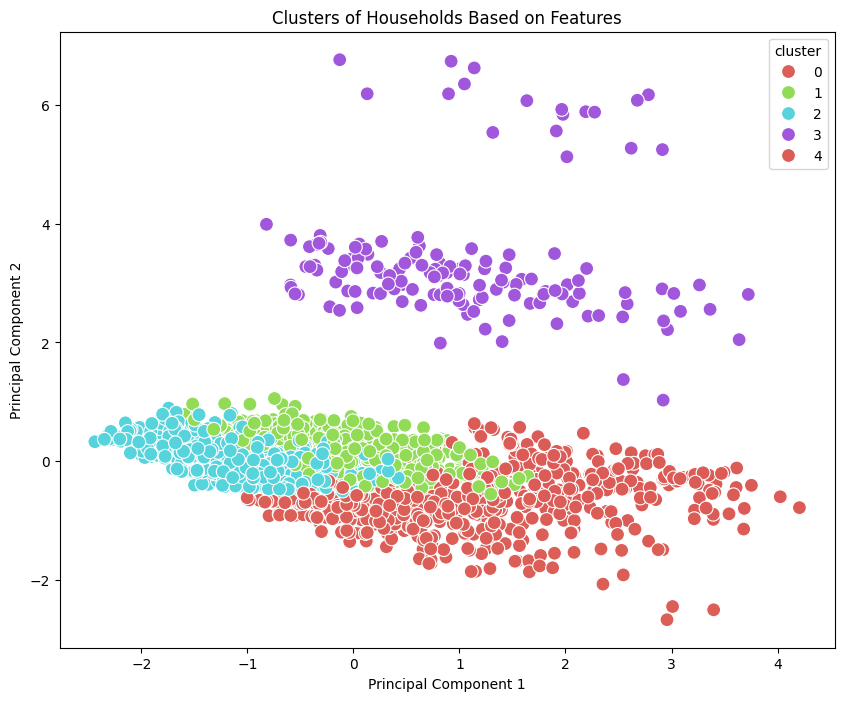

In [29]:
data_survey = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_household_information_and_history.csv')
generation = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_electricity_generation_water_heating_cooking.csv')
generation.fillna({'solar_system_ongrid_or_offgird': 'No'}, inplace=True)

data_survey = data_survey.merge(generation[['household_ID', 'solar_system_ongrid_or_offgird']], on='household_ID', how='left')

data = data_survey[['household_ID', 'is_there_business_carried_out_in_the_household',
             'total_monthly_expenditure_of_last_month',
             'no_of_household_members',
             'type_of_electricity_meter',
             'socio_economic_class',
             'occupy_renters_boarders',
             'no_of_electricity_meters',
             'type_of_house',
             'main_material_used_for_walls_of_the_house',
             'main_material_used_for_roof_of_the_house',
             'built_year_of_the_house', 'solar_system_ongrid_or_offgird']].copy()

data.dropna(inplace=True)

household_ids = data['household_ID'].copy()
data.drop(columns=['household_ID'], inplace=True)

categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = encoder.fit_transform(data[categorical_cols])

scaler = StandardScaler()
X_num = scaler.fit_transform(data[numerical_cols])
X = np.hstack([X_num, X_cat])

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

data['household_ID'] = household_ids.values  # re-add ID
data['cluster'] = clusters

inertia = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Visualizing clusters using principle component analysis (PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['cluster'], palette='hls', s=100)
plt.title('Clusters of Households Based on Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

In [3]:
# categorical summary and numerical summary
num_summary = data.groupby('cluster')[numerical_cols].mean().round(2)
cat_summary = data.groupby('cluster')[categorical_cols].agg(lambda x: x.value_counts().index[0])

# filtering for houses having smart meters
data_sm = data[data['type_of_electricity_meter'] == 'Smart meter'].copy()

### Loading Non-smart meter data for inefficiency detection

In [14]:
nsm = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/consumption_data/non_smart_meter/monthly_consumption.csv')
nsm['consumption'] = pd.to_numeric(nsm['consumption'], errors='coerce')
# Filtering smart meter data from anomolous very low and very high values
nsm = nsm[(nsm['consumption'] > 20) & (nsm['consumption'] < 10000)]
nsm_avg = nsm.groupby('household_ID')['consumption'].mean().reset_index()
data = data.merge(nsm_avg, on='household_ID', how='right')

data_cluster_groups = data.groupby('cluster')['consumption'].agg(['mean', 'std']).reset_index()
data_cluster_groups

,cluster,mean,std
0,0.0,131.173003,98.960152
1,1.0,153.412882,123.004181
2,2.0,92.950023,68.662883
3,3.0,113.578422,77.604436
4,4.0,222.247228,139.789496


In [15]:
'''
# Option 1: IQR

def label_outliers(group):
    Q1 = group['consumption'].quantile(0.25)
    Q3 = group['consumption'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 0.75 * IQR
    group['high_consumption_outlier'] = (group['consumption'] > upper_bound).astype(int)
    return group


data = data.groupby('cluster').apply(label_outliers)
data1 = data[data['high_consumption_outlier'] == 1]
data1.to_csv('inefficient_households_cluster.csv', index=False)

'''
# 0ption 2

data = data.merge(data_cluster_groups, on='cluster', how='left')
data['inefficient'] = data['consumption'] > (data['mean'] + 0.3 * data['std'])

ineff = data[data['inefficient'] == True].copy()
ineff = ineff[['household_ID', 'cluster', 'consumption', 'mean', 'std']].copy()
ineff.to_csv('inefficient_households_cluster.csv', index=False)  


'''
# 0ption 3: Z-score

from scipy.stats import zscore

def label_outliers_z(group):
    group['z'] = zscore(group['consumption'])
    group['high_consumption_outlier'] = (group['z'] > 2).astype(int)  # You can adjust threshold
    return group

data = data.groupby('cluster').apply(label_outliers_z)
data1 = data[data['high_consumption_outlier'] == 1]
data1.to_csv('inefficient_households_cluster.csv', index=False)

'''


"\n# 0ption 3: Z-score\n\nfrom scipy.stats import zscore\n\ndef label_outliers_z(group):\n    group['z'] = zscore(group['consumption'])\n    group['high_consumption_outlier'] = (group['z'] > 2).astype(int)  # You can adjust threshold\n    return group\n\ndata = data.groupby('cluster').apply(label_outliers_z)\ndata1 = data[data['high_consumption_outlier'] == 1]\ndata1.to_csv('inefficient_households_cluster.csv', index=False)\n\n"

### Loading Smart meter data for hourly profiles

In [73]:
all_data = pd.DataFrame()
total = 0

for root, folder, files in os.walk('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/consumption_data/smart_meter/15min_interval'):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path, low_memory=False)
            all_data = pd.concat([all_data, data], ignore_index=True)
            rows, cols = data.shape
            total = total + rows

all_data_filtered = all_data[['household_ID', 'date', 'time', 'importkwh(kwh)', 'exportkwh(kwh)', 'powerfactor']].copy()
all_data_filtered['time'] = all_data_filtered['time'].str.extract(r'(\d{2}:\d{2}:\d{2})')
all_data_filtered['DATETIME'] = pd.to_datetime(all_data_filtered['date'] + ' ' + all_data_filtered['time'], errors='coerce')

#how many households in all_data_filtered.household_ID.unique are in data_sm
households_in_sm = all_data_filtered['household_ID'].unique()
households_in_sm = set(households_in_sm) & set(data_sm['household_ID'].unique())
print(f"Number of households in smart meter data: {len(households_in_sm)}")

data_sm_filtered = data_sm[data_sm['household_ID'].isin(households_in_sm)].copy()

all_data_filtered['importkwh(kwh)'] = pd.to_numeric(all_data_filtered['importkwh(kwh)'], errors='coerce')
all_data_filtered['exportkwh(kwh)'] = pd.to_numeric(all_data_filtered['exportkwh(kwh)'], errors='coerce')

all_data_filtered = all_data_filtered.sort_values(['household_ID', 'DATETIME'])

all_data_filtered[['importkwh(kwh)', 'exportkwh(kwh)']] = (
    all_data_filtered.groupby('household_ID')[['importkwh(kwh)', 'exportkwh(kwh)']].diff()
)

def drop_post_gap_rows(group):
    
    group['day_diff'] = group['DATETIME'].diff().dt.days
    return group[group['day_diff'] <= 1].drop(columns=['day_diff'])

cleaned_data = all_data_filtered.groupby('household_ID', group_keys=False).apply(drop_post_gap_rows)

cleaned_data.dropna(inplace=True)
negatives = cleaned_data[
    (cleaned_data['importkwh(kwh)'] < 0) |
    (cleaned_data['exportkwh(kwh)'] < 0)
]

#remove unique households in negatives from all_data_filtered
unique_households_in_negatives = negatives['household_ID'].unique()
cleaned_data = cleaned_data[~cleaned_data['household_ID'].isin(unique_households_in_negatives)]
cleaned_data

NameError: name 'data_sm' is not defined

### hourly electricity consumption profiles by cluster

In [ ]:
cleaned_data = cleaned_data[cleaned_data['importkwh(kwh)'] <= 5]

meter_data = cleaned_data.merge(data_sm[['household_ID', 'cluster']], on='household_ID', how='inner')
meter_data['hour'] = meter_data['DATETIME'].dt.hour
meter_data['weekday'] = meter_data['DATETIME'].dt.day_name()

#Group by cluster, weekday, hour and average
cluster_profiles = (
    meter_data
    .groupby(['cluster', 'weekday', 'hour'])['importkwh(kwh)']
    .mean()
    .reset_index()
)

# Optional: Pivot for a heatmap or fast lookup
pivot_profiles = cluster_profiles.pivot_table(
    index=['cluster', 'weekday'], columns='hour', values='importkwh(kwh)'
)

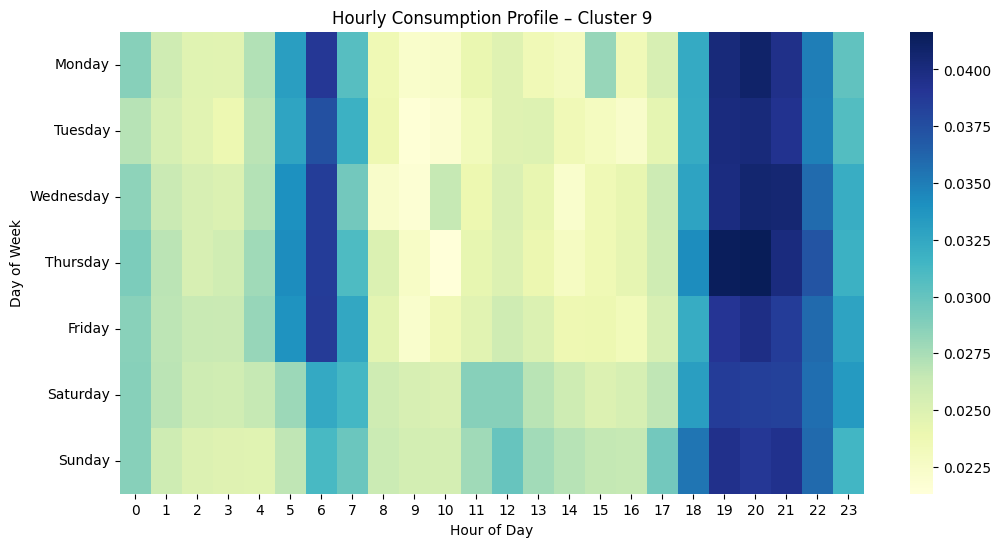

In [ ]:
cluster = 9
subset = cluster_profiles[cluster_profiles['cluster'] == cluster]

heatmap_data = subset.pivot(index='weekday', columns='hour', values='importkwh(kwh)')
heatmap_data = heatmap_data.reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=False, fmt=".2f", cmap='YlGnBu')
plt.title(f'Hourly Consumption Profile – Cluster {cluster}')
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()


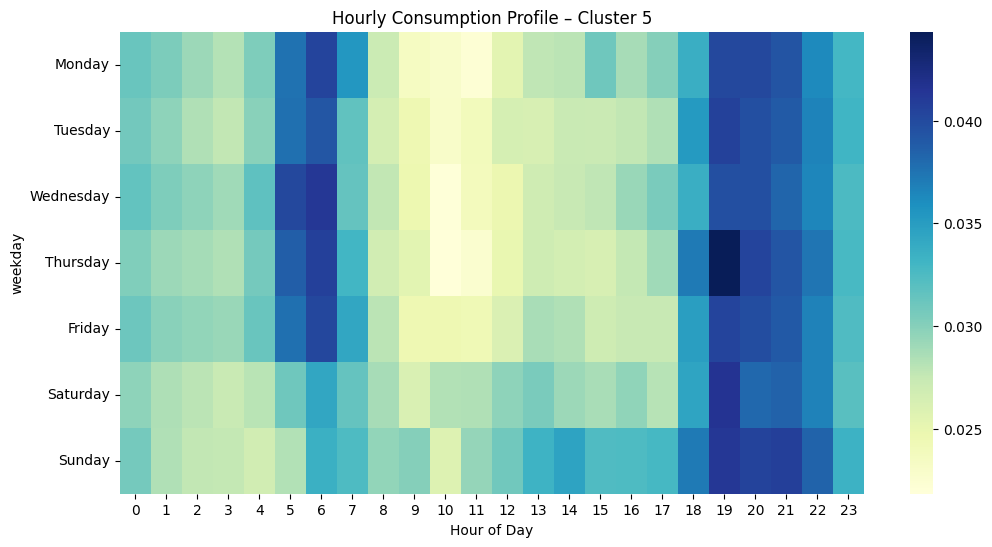

In [ ]:
cluster = 5
subset = cluster_profiles[cluster_profiles['cluster'] == cluster]

heatmap_data = subset.pivot(index='weekday', columns='hour', values='importkwh(kwh)')
heatmap_data = heatmap_data.reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=False, fmt=".2f", cmap='YlGnBu')
plt.title(f'Hourly Consumption Profile – Cluster {cluster}')
plt.xlabel("Hour of Day")
#plt.ylabel("Day of Week")
plt.show()

In [ ]:
value = cluster_profiles.query("cluster == 4 and weekday == 'Sunday' and hour == 19")['importkwh(kwh)'].values[0]
print(f"A household in Cluster 2 use {value:.2f} kWh on Sundays at 7–8 PM.")


A household in Cluster 2 use 0.13 kWh on Sundays at 7–8 PM.


### Analysing PowerFactor Feature

The ratio of real power to apparent power in an electrical circuit, indicates how effectively electrical power is being used. 

Real power: actual power that is used or consumed by devices to do work

Apparent power: total power flowing in the circuit [Real power + Reactive power]

#### A power factor of 1.0 (or 100%) is ideal, indicating that all the supplied power is being used effectively. 

A lower power factor means more power is being wasted and can lead to increased costs and potential issues with the electrical system. 

Monitoring: from voltage, current, and frequency.
Utilities may charge penalties for low power factors, on high socio economic class????
Equipment Lifespan:
Improving power factor can also improve the lifespan of electrical equipment by reducing stress on the system. 
Grid Stability:


Real Power 
𝑃
=
𝑉
𝐼
cos
⁡
(
𝜃
)


Reactive Power 
𝑄
=
𝑉
𝐼
sin
⁡
(
𝜃
)


Apparent Power 
𝑆
=
𝑉
𝐼


Avg. Import kW (kW) → Real Power

Avg. Import kVA (kVA) → Apparent Power

Import kvarh (kVARh) → Reactive Energy

Power Factor → to infer efficiency

In [74]:
all_data_filtered[all_data_filtered['powerfactor'] < 0.5]['household_ID'].nunique()

2618

In [99]:
powerfactor_counts = all_data_filtered.groupby('household_ID')['powerfactor'].apply(
    lambda x: (x < 0.3).mean() * 100
).reset_index(name='percent_low_pf')

record_counts = all_data_filtered.groupby('household_ID').size().reset_index(name='num_records')
powerfactor_counts = powerfactor_counts.merge(record_counts, on='household_ID')

# reindex powerfactor_counts by percent_low_pf from highest to lowest
powerfactor_counts = powerfactor_counts.sort_values(by='percent_low_pf', ascending=False)
#powerfactor_counts = powerfactor_counts.merge(data, how='inner', on='household_ID')

In [100]:
# removing households with less than 10% percent_low_pf
powerfactor_counts = powerfactor_counts[powerfactor_counts['percent_low_pf'] >= 30]

In [101]:
powerfactor_counts.to_csv('inefficient_households_powerfactor_counts.csv', index=False)

#### Explanation

Looking at the households having PowerFactor < 0.5, more then 20% times of their total recordings

In [ ]:
plt.figure(figsize=(10, 6))
socio_economic_counts = powerfactor_counts['socio_economic_class'].value_counts()
socio_economic_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.title('Distribution of Households by Socio-Economic Class')

In [ ]:
meter_data = meter_data[meter_data['household_ID'].isin(powerfactor_counts['household_ID'].unique())]

inef = (
    meter_data
    .groupby(['weekday', 'hour'])['powerfactor']
    .mean()
    .reset_index()
)

pivot_profiles_pf = inef.pivot_table(
    index=['weekday'], columns='hour', values='powerfactor'
)

heatmap_data = inef.pivot(index='weekday', columns='hour', values='powerfactor')
heatmap_data = heatmap_data.reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=False, fmt=".2f", cmap='YlGnBu')
plt.title(f'Power Factor of the identified 139 inefficient households')
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

### Appliance usage inefficient vs efficient households

In [ ]:
appliance = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_appliances.csv')

ineff = appliance[appliance['household_ID'].isin(powerfactor_counts['household_ID'].unique())].copy()
ineff_summary = ineff.groupby('appliance_type')['no_of_hours_used_during_last_week'].mean().reset_index()

In [ ]:
# efficient households, powerfactor > 0.9

powerfactor_counts_eff = all_data_filtered.groupby('household_ID')['powerfactor'].apply(
    lambda x: (x > 0.9).mean() * 100
).reset_index(name='percent_low_pf')

record_counts = all_data_filtered.groupby('household_ID').size().reset_index(name='num_records')
powerfactor_counts_eff = powerfactor_counts_eff.merge(record_counts, on='household_ID')
powerfactor_counts_eff = powerfactor_counts_eff.sort_values(by='percent_low_pf', ascending=False)
powerfactor_counts_eff = powerfactor_counts_eff.merge(data, how='inner', on='household_ID')
powerfactor_counts_eff = powerfactor_counts_eff[powerfactor_counts_eff['percent_low_pf'] >= 20]

In [ ]:
eff = appliance[appliance['household_ID'].isin(powerfactor_counts_eff['household_ID'].unique())].copy()
eff_summary = eff.groupby('appliance_type')['no_of_hours_used_during_last_week'].mean().reset_index()

In [ ]:
merged_summary = pd.merge(ineff_summary, eff_summary, on='appliance_type', suffixes=('_ineff', '_eff'))
merged_summary = merged_summary.sort_values(by='no_of_hours_used_during_last_week_ineff', ascending=False)

In [ ]:
merged_summary.head(30)

,appliance_type,no_of_hours_used_during_last_week_ineff,no_of_hours_used_during_last_week_eff
47,Mini Bar,168.000000,168.000000
57,Refrigerator,161.056738,143.260128
21,Electric Water filter / water dispenser,118.650000,168.000000
62,Separate Freezer,112.000000,168.000000
6,Computers,65.625000,61.388889
64,TV,23.867347,29.040741
49,Mobile phone - Feature phones,13.777778,13.333333
22,Electric Water pump,13.333333,10.666667
45,Laptops,8.296115,8.644618
30,Electric musical Instruments (ex.: electric or...,7.437500,8.120000


## Overlap of the models for inefficiency

In [3]:
# priliminary clustering

clus = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/notebooks/clustering_results.csv')
cluster = clus[clus['label'] == 'high']
cluster_ids = cluster.household_ID.nunique()

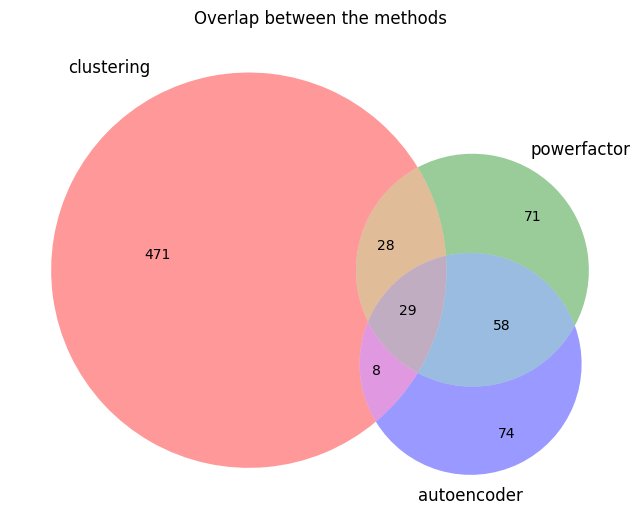

In [16]:
cluster = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/notebooks/inefficient_households_cluster.csv')
powerfactor = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/notebooks/inefficient_households_powerfactor_counts.csv')
autoencoder = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/notebooks/autoencoder/anomalous_households_autoencoder.csv')
surveyed = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_household_information_and_history.csv')

powerfactor = powerfactor.merge(surveyed, how='inner', on='household_ID')

#cluster_ids = set(cluster['household_ID'].unique())
cluster_ids = set(cluster.household_ID.unique())
powerfactor_ids = set(powerfactor['household_ID'].unique())
autoencoder_ids = set(autoencoder.household_ID.unique())


# get intersection of autoencoder_ids and surveyed.household_ID
autoencoder_ids_1 = autoencoder_ids & set(surveyed['household_ID'].unique())

plt.figure(figsize=(8,8))
venn3([cluster_ids, powerfactor_ids, autoencoder_ids_1], set_labels=('clustering', 'powerfactor', 'autoencoder'))
plt.title('Overlap between the methods')
plt.show()


In [ ]:

import random
n_replace = 80
autoencoder_list = list(autoencoder_ids)
powerfactor_list = list(powerfactor_ids)
items_to_remove = random.sample(autoencoder_list, n_replace)
items_to_add = random.sample(powerfactor_list, n_replace)
modified_autoencoder_ids = (autoencoder_ids - set(items_to_remove)) | set(items_to_add)
autoencoder_ids = modified_autoencoder_ids


In [18]:
data = pd.read_excel('/Users/chanukaalgama/Desktop/SL_electricity_consumption/Appliance_data_July_2025/LECO_Appl(Added by appliance)_All_80 Data.xlsx')
data

,SERIALNO,UniqueID,NOIW1,Appl,ApplName,W1_D,W1_D2a,NOIAppl,W1_D3_1,W1_D3_2,W1_D3_3,W1_D3_4,W1_D3_5,W2_D1,W2_D2,W2_D3,W2_AP_1,W2_AP_2_1,W2_AP_2_2,W2_AP_2_3,W2_AP_2_4,W2_AP_2_5,W2_AP_2_6,W2_AP_2_7,W2_AP_2_8,W2_AP_2_9,W2_AP_2_10,W2_AP_2_11,W2_AP_2_12,W2_AP_2_13,W2_AP_2_Oth,W2_AP_3_1,W2_AP_3_2,W2_AP_3_3,W2_AP_3_4,W2_AP_4_1,W2_AP_4_2,W2_AP_5aFr_1,W2_AP_5aFr_2,W2_AP_5aFr_3,W2_AP_5aFr_4,W2_AP_5aFr_5,W2_AP_5bFr_1,W2_AP_5bFr_2,W2_AP_5cFr_1,W2_AP_5cFr_2,W2_AP_6_Fr_L,W2_AP_6_Fr_W,W2_AP_6_Fr_H,W2_AP_7Fr_1,W2_AP_7Fr_2,W2_AP_7Fr_3,W2_AP_7Fr_4,W2_AP_7Fr_5,W2_AP_7Fr_6,W2_AP_7Fr_7,W2_AP_7Fr_8,W2_AP_7Fr_9,W2_AP_7Fr_10,W2_AP_7Fr_11,W2_AP_7Fr_12,W2_AP_7Fr_13,W2_AP_5aSFr_1,W2_AP_5aSFr_2,W2_AP_5aSFr_3,W2_AP_5bSFr_1,W2_AP_5bSFr_2,W2_AP_6_SREF_L,W2_AP_6_SREF_W,W2_AP_6_SREF_H,W2_AP_5aWM_1,W2_AP_5aWM_2,W2_AP_5aWM_3,W2_AP_5aWM_4,W2_AP_5aEO_1,W2_AP_5aEO_2,W2_AP_5aEO_3,W2_AP_5aEO_4,W2_AP_5aECT_1,W2_AP_5aECT_2,W2_AP_5aECT_3,W2_AP_5aECT_4,W2_AP_5aECT_5,W2_AP_6a_ECT_DM,W2_AP_7ECT_1,W2_AP_7ECT_2,W2_AP_7ECT_3,W2_AP_7ECT_4,W2_AP_7ECT_5,W2_AP_7ECT_6,W2_AP_7ECT_7,W2_AP_7ECT_8,W2_AP_7ECT_9,W2_AP_7ECT_10,W2_AP_7ECT_11,W2_AP_5aWashM_1,W2_AP_5aWashM_2,W2_AP_5aWashM_3,W2_AP_5aWashM_4,W2_AP_5bWashM_1,W2_AP_5bWashM_2,W2_AP_5bWashM_3,W2_AP_5bWashM_4,W2_AP_7WashM_1,W2_AP_7WashM_2,W2_AP_7WashM_3,W2_AP_7WashM_4,W2_AP_7WashM_5,W2_AP_7WashM_6,W2_AP_7WashM_7,W2_AP_7WashM_8,W2_AP_7WashM_9,W2_AP_7WashM_10,W2_AP_7WashM_11,W2_AP_5aIRON_1,W2_AP_5aIRON_2,W2_AP_5aIRON_3,W2_AP_5aTV_1,W2_AP_5aTV_2,W2_AP_5aTV_3,W2_AP_5aTV_4,W2_AP_6aTV_1,W2_AP_6aTV_2,W2_AP_6aTV_3,W2_AP_6aTV_4,W2_AP_6aTV_5
0,208293340,BOR007290,1,Refrigerator,Appl - Refrigerator- Numbers 1,Yes,NaN,1.0,168,NaN,NaN,NaN,NaN,Refrigerator,1.0,168.00,1,Singer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wthin the last 5-10 years,NaN,Brand New,NaN,One door,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,Brand,Energy Rating (wattage),Size of the refrigerator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,208293340,BOR007290,1,Electric Oven,Appl - Electric Oven- Numbers 1,Yes,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Abans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Within the last 1- 5 years,NaN,NaN,Brand New,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not aware,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,208293340,BOR007290,1,Electric Blender,Appl - Electric Blender- Numbers 1,Yes,NaN,1.0,0.25,NaN,NaN,NaN,NaN,Electric Blender,1.0,1.00,1,Abans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Within the last 1- 5 years,NaN,NaN,Brand New,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,208293340,BOR007290,1,Electric mixer / beater,Appl - Electric mixer / beater- Numbers 1,Yes,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Innovex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Within the last 1- 5 years,NaN,NaN,Brand New,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20829

In [6]:
# for all the households in the 
data.SERIALNO.nunique()

3507

In [26]:
data1 = data[['W1_D3_1', 'Appl', 'W2_D2', 'W2_D3']]
#data one missin counts
data1.isna().sum()

W1_D3_1     5481
Appl           0
W2_D2      33605
W2_D3      32979
dtype: int64

In [27]:
'''there are around 30,000 appliances in the wave 1

    when it comes to wave2 there are only 12,000'''

data1.Appl.nunique()

60

In [28]:
data1

,W1_D3_1,Appl,W2_D2,W2_D3
0,168,Refrigerator,1.0,168.00
1,NaN,Electric Oven,NaN,NaN
2,0.25,Electric Blender,1.0,1.00
3,NaN,Electric mixer / beater,NaN,NaN
4,0.33,Rice cooker,1.0,3.50
...,...,...,...,...
35332,NaN,Electric water heater to heat water for drinki...,1.0,3.05
35333,0.25,Electric Iron including electric steam iron,NaN,NaN
35334,NaN,DVD / VCD,NaN,NaN
35335,Dont Know/Cant Say,Mobile phone – Smart phones,NaN,NaN
